In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import re

from numpy.linalg import inv, cholesky
from scipy.stats import invwishart, multivariate_normal
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

import functions as func

az.style.use("arviz-darkgrid")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_pickle("2023-10.pkl")
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.index = pd.to_datetime(df.index)

In [4]:
split_date = pd.to_datetime("2022-07-01")

data = df.loc[:split_date,:]
test_data = df.loc[split_date:,:]

In [5]:
from matplotlib.colors import ColorConverter
colors = ("C0", "C1")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
    "C2": tuple(c * .35 for c in (ColorConverter.to_rgb("C2"))),
    "C3": tuple(c * .35 for c in (ColorConverter.to_rgb("C3"))),
}

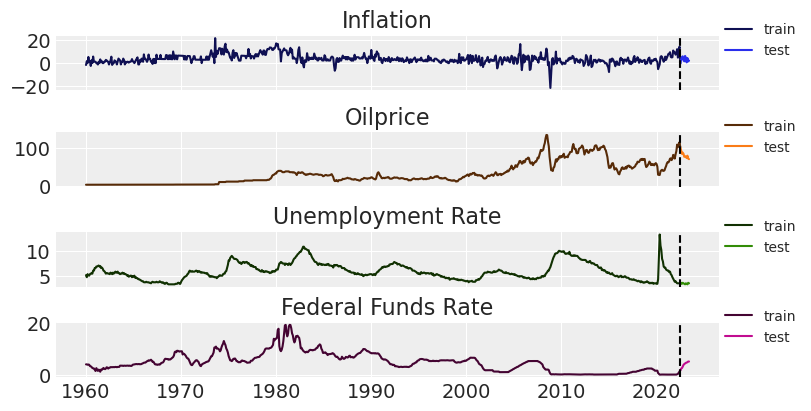

In [6]:
_, ax = plt.subplots(4, 1, figsize=(8, 4), sharex=True)

ax[0].plot(data["inflation"], color=dark["C0"], label="train")
ax[0].plot(test_data["inflation"], color="C0", label="test")
ax[0].set_title("Inflation")

ax[1].plot(data["OILPRICEx"], color=dark["C1"], label="train")
ax[1].plot(test_data["OILPRICEx"], color="C1", label="test")
ax[1].set_title("Oilprice");

ax[2].plot(data["UNRATE"], color=dark["C2"], label="train")
ax[2].plot(test_data["UNRATE"], color="C2", label="test")
ax[2].set_title("Unemployment Rate");

ax[3].plot(data["FEDFUNDS"], color=dark["C3"], label="train")
ax[3].plot(test_data["FEDFUNDS"], color="C3", label="test")
ax[3].set_title("Federal Funds Rate");

for axi in ax:
    axi.axvline(df.index[-12], ls="--", color="k")
    axi.legend(loc=(1, 0.5), fontsize=10)

Difference dataframe to achieve stationarity

In [8]:
non_stationary_vars = func.get_non_stat_vars(df)
diff_df = df
diff_df[non_stationary_vars] = df[non_stationary_vars].diff()

non_stationary_vars_diff = func.get_non_stat_vars(diff_df)
diff_diff_df = diff_df
diff_diff_df[non_stationary_vars_diff] = diff_df[non_stationary_vars_diff].diff()

non_stationary_vars_diff_diff = func.get_non_stat_vars(diff_diff_df)
diff_diff_df = diff_diff_df.dropna()
X_diff, y_diff, X_diff_test, y_diff_test = func.train_test_split(diff_diff_df, split_date)

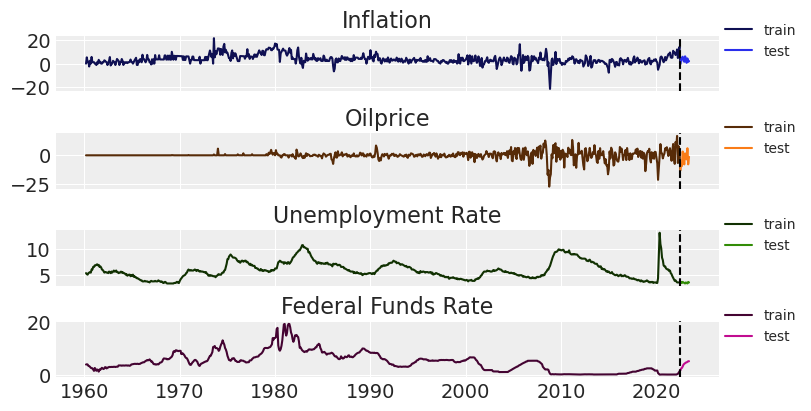

In [9]:
_, ax = plt.subplots(4, 1, figsize=(8, 4), sharex=True)

ax[0].plot(y_diff, color=dark["C0"], label="train")
ax[0].plot(y_diff_test, color="C0", label="test")
ax[0].set_title("Inflation")

ax[1].plot(X_diff["OILPRICEx"], color=dark["C1"], label="train")
ax[1].plot(X_diff_test["OILPRICEx"], color="C1", label="test")
ax[1].set_title("Oilprice");

ax[2].plot(X_diff["UNRATE"], color=dark["C2"], label="train")
ax[2].plot(X_diff_test["UNRATE"], color="C2", label="test")
ax[2].set_title("Unemployment Rate");

ax[3].plot(X_diff["FEDFUNDS"], color=dark["C3"], label="train")
ax[3].plot(X_diff_test["FEDFUNDS"], color="C3", label="test")
ax[3].set_title("Federal Funds Rate");

for axi in ax:
    axi.axvline(df.index[-12], ls="--", color="k")
    axi.legend(loc=(1, 0.5), fontsize=10)

### BVAR Modeling

$y_t = \alpha_0 + \sum^p_{j=1}A_j y_{t-j} + e_t$

In [10]:
nruns = 10000           # Final number of draws to save
burn_in = 1000          # Draws to discard (burn-in)
B = nruns + burn_in     # Total number of draws

ndraws = 10             # Number of times to obtain a draw from the predictive density, for each generated draw of the parameters
h = 12                  # Number of periods in the future for T+h forecasts
p = 2                   # Number of lags in the VAR

In [11]:
def make_data(df, p, h, vars, intercept = True):
    """
    Shape data for the BVAR model.
    """
    cols = ["inflation"] + vars
    BVAR_df = df.loc[:, cols]
    BVAR_df = BVAR_df.reset_index(drop=True)
    Traw, M = BVAR_df.shape
    Traw = Traw - h - 1

    Y1 = BVAR_df.loc[h+1:,:].reset_index(drop=True)
    Y1 = Y1.loc[(p+1):Traw,:].reset_index(drop=True)

    Y2 = BVAR_df.loc[2:len(BVAR_df)-h,:].reset_index(drop=True)
    lag_cols = [f"{col}_lag{i+1}" for i in range(p) for col in cols]
    Y2[lag_cols] = func.make_lagged_vars(Y2.values, p)
    
    if intercept:
        X1 = pd.concat([pd.DataFrame(np.ones((Traw-p-1, 1)), columns=["intercept"]), Y2.loc[(p+1):Traw, :].reset_index(drop=True)], axis=1)
        X1 = X1.drop(columns=cols)
    else:
        X1 = Y2.loc[(p+1):Traw, :].reset_index(drop=True)
        X1 = X1.drop(columns=cols)

    T = Traw - p - 1

    Y = Y1.loc[:len(Y1)-1, :].to_numpy()    # Exclude the last observation
    X = X1.loc[:len(X1)-1, :].to_numpy()    # Exclude the last observation
    Z = np.kron(np.eye(M), X)               # Matrix containing the regressors for each equation on the diagonal
    K = X1.shape[1]                         # Number of regressors including the intercept and lags
    
    return Y, Y1, X, Z, T, K, M

In [12]:
Y, Y1, X, Z, T, K, M = make_data(diff_diff_df, 2, 12, ["OILPRICEx", "UNRATE", "FEDFUNDS"])

In [13]:
# Matrices for storing results
Y_pred = np.zeros((nruns*ndraws, M))        
Y_pred_th = np.zeros((nruns*ndraws,h, M))   
PL = np.zeros((nruns, 1))                   
alpha_draws = np.zeros((nruns,K*M))         
ALPHA_draws = np.zeros((nruns,K,M))
SIGMA_draws = np.zeros((nruns,M,M))
n = K*M 

In [14]:
def OLS_est(X, Y):
    # This is the matrix of OLS regression coefficients
    ALPHA_OLS = inv(X.T @ X) @ (X.T @ Y)
    # a_OLS = vec(A_OLS)
    alpha_OLS = ALPHA_OLS.flatten()
    # Sum of squared errors
    SSE = (Y - X @ ALPHA_OLS).T @ (Y - X @ ALPHA_OLS)
    # Calculate SIGMA_OLS
    SIGMA_OLS = SSE / (T - K + 1)

    return alpha_OLS, ALPHA_OLS, SIGMA_OLS

In [15]:
alpha, ALPHA, SIGMA = OLS_est(X, Y)

In [16]:
sampling_params = dict()
sampling_params["T"] = T
sampling_params["K"] = K
sampling_params["M"] = M
sampling_params["n"] = n
sampling_params["p"] = p
sampling_params["alpha_init"] = alpha
sampling_params["ALPHA_init"] = ALPHA
sampling_params["SIGMA_init"] = SIGMA
sampling_params["Z"] = Z
sampling_params["Y"] = Y
sampling_params["X"] = X
sampling_params["Y1"] = Y1
sampling_params["Y_pred_th"] = Y_pred_th
sampling_params["alpha_draws"] = alpha_draws
sampling_params["ALPHA_draws"] = ALPHA_draws
sampling_params["SIGMA_draws"] = SIGMA_draws

In [17]:
def gibbs_sampler(B, burn_in, ndraws, h, params):
    T = params["T"]
    K = params["K"]
    M = params["M"]
    n = params["n"]
    p = params["p"]
    alpha = params["alpha_init"]
    ALPHA = params["ALPHA_init"]
    SIGMA = params["SIGMA_init"]
    Z = params["Z"]
    Y = params["Y"]
    Y1 = params["Y1"]
    X = params["X"]
    Y_pred_th = params["Y_pred_th"]
    alpha_draws = params['alpha_draws']
    ALPHA_draws = params['ALPHA_draws']
    SIGMA_draws = params['SIGMA_draws']

    # Prior mean of alpha
    a_prior = np.zeros((n, 1))
    # Prior variance of alpha
    V_prior = 10 * np.eye(n)
    # Prior Degrees of Freedom of Wishart dist for SIGMA
    nu_prior = M
    # Prior scale of Wishart dist for SIGMA
    S_prior = np.eye(M)

    # Gibbs sampling loop
    for i in tqdm(range(B)):
        VARIANCE = np.kron(inv(SIGMA), np.eye(T))
        V_post = inv(inv(V_prior) + Z.T @ VARIANCE @ Z)
        a_post = V_post @ (inv(V_prior) @ a_prior + (Z.T @ VARIANCE @ Y.flatten()).reshape(n, 1))
        # Posterior of alpha|SIGMA,y ~ N(a_post,V_post)
        alpha = a_post + cholesky(V_post).T @ np.random.randn(n, 1)     
        ALPHA = alpha.reshape(K, M)  

        nu_post = T + nu_prior
        S_post = S_prior + (Y - X @ ALPHA).T @ (Y - X @ ALPHA)
        # Posterior of SIGMA|ALPHA,y ~ iW(inv(S_post),v_post)
        SIGMA = invwishart.rvs(df=nu_post, scale=inv(S_post))

        if i > burn_in:
            Y_temp_store = np.zeros((ndraws, M))
            Y_Tplush = np.zeros((ndraws, h, M))

            for draw in range(ndraws-1):
                X_tplus1 = np.hstack([1, Y[-1, :], X[-1, 1:M*(p-1)+1]])
                # Forecast of T+1 conditional on data at time T
                Y_hat = X_tplus1 @ ALPHA + np.random.randn(1, M) @ cholesky(SIGMA)  
                Y_temp = Y_hat
                X_new = X_tplus1

                Y_hat_tplush = np.zeros((h, M))
                Y_hat_tplush[0,:] = Y_hat

                for t in range(1,h):
                    if t <= p:
                        X_new = np.hstack([1, np.squeeze(Y_hat), X_tplus1[1:M*(p-t)+1]]) 
                        Y_temp = X_new @ ALPHA + np.random.randn(1, M) @ cholesky(SIGMA) 
                        Y_hat = np.hstack([Y_hat, Y_temp])
                        Y_hat_tplush[t,:] = Y_temp
                    else:
                        X_new = np.hstack([1, np.squeeze(Y_hat[:, :M*p])])      
                        Y_temp = X_new @ ALPHA + np.random.randn(1, M) @ cholesky(SIGMA)
                        Y_hat = np.hstack([Y_hat, Y_temp])
                        Y_hat_tplush[t,:] = Y_temp

                Y_temp_store[draw, :] = Y_temp
                Y_Tplush[draw,:,:] = Y_hat_tplush

            # Matrix of predictions
            Y_pred_th[((i - burn_in) - 1) * ndraws:(i - burn_in) * ndraws, :, :] = Y_Tplush
        
            # Storing the draws for each parameter
            alpha_draws[i - burn_in, :] = np.squeeze(alpha)
            ALPHA_draws[i - burn_in, :, :] = ALPHA
            SIGMA_draws[i - burn_in, :, :] = SIGMA

    return Y_pred, Y_pred_th, PL, alpha_draws, ALPHA_draws, SIGMA_draws

In [18]:
Y_pred, Y_pred_th, PL, alpha_draws, ALPHA_draws, SIGMA_draws = gibbs_sampler(B, burn_in, ndraws, h, sampling_params)

100%|██████████| 11000/11000 [14:38<00:00, 12.53it/s] 


In [31]:
def predictive_mean(Z, alpha_draws, var_num=1):
    total = 0
    T = int(len(Z)/4)
    var_num = var_num 

    for r in range(alpha_draws.shape[0]):
        total += Z[(T*var_num-h):(T*var_num),:] @ alpha_draws[r,:]

    return total / alpha_draws.shape[0]

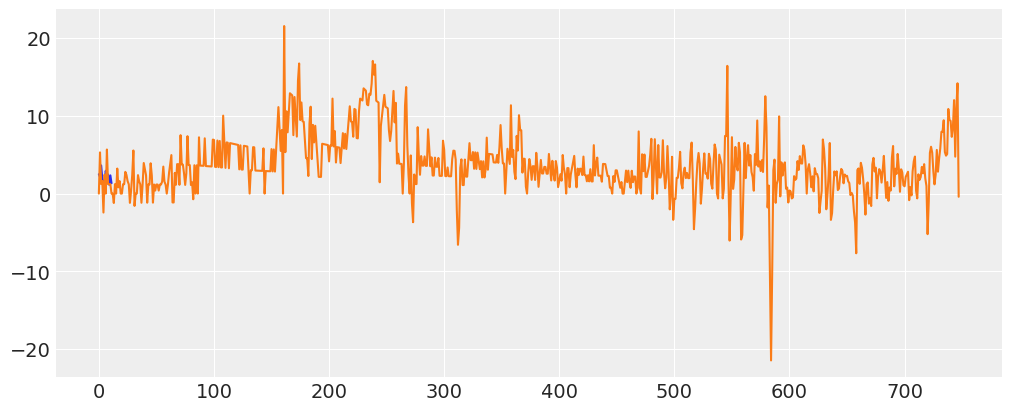

In [32]:
pred_mean = predictive_mean(Z, alpha_draws, var_num=1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(pred_mean)
ax.plot(y_diff.values)

In [19]:
ALPHA_mean = np.mean(ALPHA_draws[burn_in:], axis=0)
SIGMA_mean = np.mean(SIGMA_draws[burn_in:], axis=0)
y_hat_train = X @ ALPHA_mean + np.random.randn(1, M) @ cholesky(SIGMA_mean)

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_4712/779821946.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


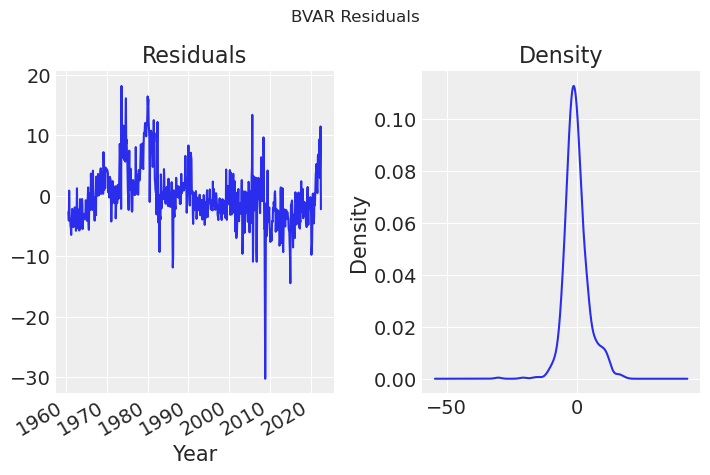

In [20]:
resid = y_diff.iloc[5:] - y_hat_train[:,0]

fig, ax = plt.subplots(1,2)
resid.plot(title='Residuals', ax=ax[0])
ax[0].set_xlabel('Year')
resid.plot(title='Density', kind='kde', ax=ax[1])
plt.suptitle('BVAR Residuals')
plt.tight_layout()
# plt.savefig('BVAR_resid.png', dpi=150)
plt.show()

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_5844/2914773528.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


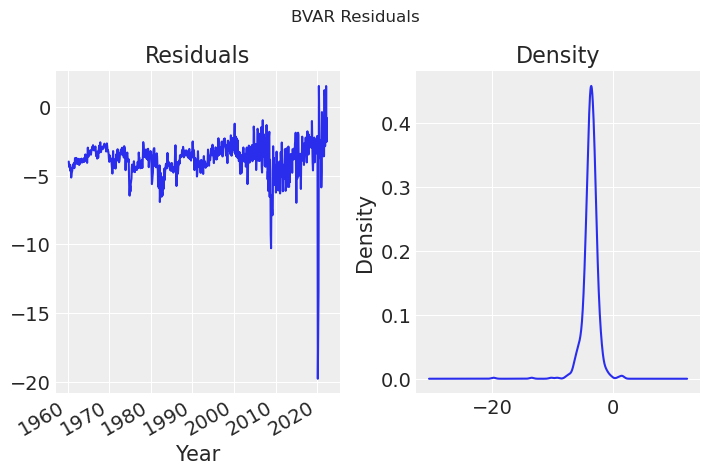

In [ ]:
bvar_resid = y_diff[3:-2] - y_pred_train

fig, ax = plt.subplots(1,2)
bvar_resid.plot(title='Residuals', ax=ax[0])
ax[0].set_xlabel('Year')
bvar_resid.plot(title='Density', kind='kde', ax=ax[1])
plt.suptitle('BVAR Residuals')
plt.tight_layout()
plt.show()

In [24]:
# posterior mean of alpha
alpha_mean = np.mean(alpha_draws[burn_in:], axis=0).squeeze()

# posterior mean of ALPHA
ALPHA_mean = np.mean(ALPHA_draws[burn_in:], axis=0).squeeze()

# posterior mean of SIGMA
SIGMA_mean = np.mean(SIGMA_draws[burn_in:], axis=0).squeeze()

# mean prediction and log predictive likelihood
Y_pred_mean = np.mean(Y_pred_th[burn_in:], axis=0)
log_PL = np.mean(np.log(PL[burn_in:]), axis=0)

# This is the true value of Y at T+h:
# true_value = Y1.loc[T-h, :]

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_4712/1703709061.py:12: RuntimeWarning: divide by zero encountered in log
  log_PL = np.mean(np.log(PL[burn_in:]), axis=0)


# Get fitted values of BVAR

In [28]:
Y_fit = X @ ALPHA_mean
Y_fit_df = pd.DataFrame(Y_fit)
Y_fit_df.index = Y1.index
Y_fit_df.columns = Y1.columns

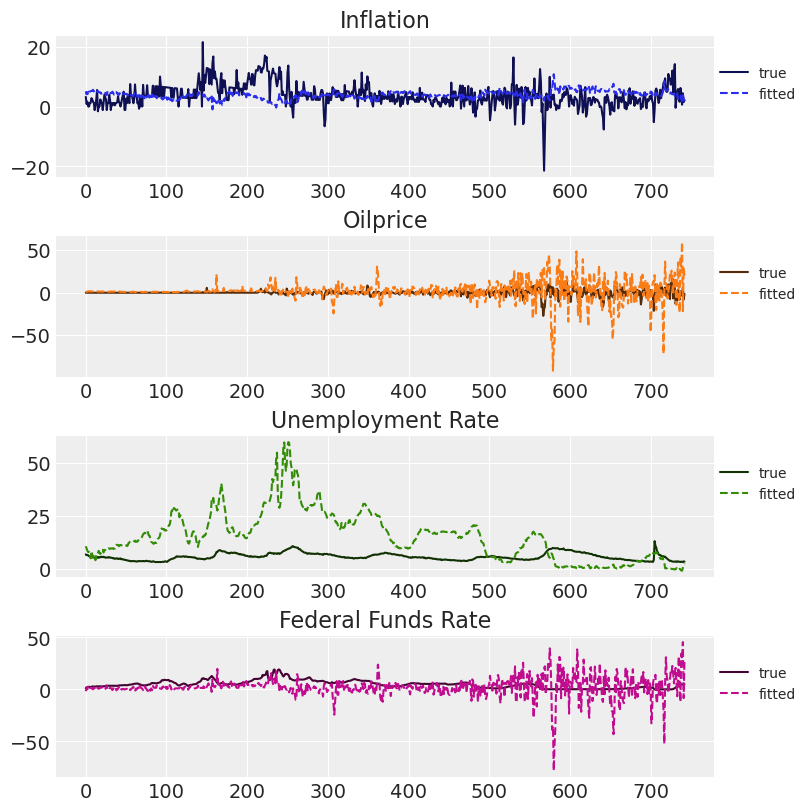

In [30]:
fig, ax = plt.subplots(4, 1, figsize=(8, 8))
ax[0].plot(Y1["inflation"], color=dark["C0"], label="true") 
ax[0].plot(Y_fit_df["inflation"], color="C0", ls="--", label="fitted")
ax[0].set_title("Inflation")
ax[0].legend(loc=(1, 0.5), fontsize=10)

ax[1].plot(Y1["OILPRICEx"], color=dark["C1"], label="true")
ax[1].plot(Y_fit_df["OILPRICEx"], color="C1", ls="--", label="fitted")
ax[1].set_title("Oilprice")
ax[1].legend(loc=(1, 0.5), fontsize=10)

ax[2].plot(Y1["UNRATE"], color=dark["C2"], label="true")
ax[2].plot(Y_fit_df["UNRATE"], color="C2", ls="--", label="fitted")
ax[2].set_title("Unemployment Rate")
ax[2].legend(loc=(1, 0.5), fontsize=10)

ax[3].plot(Y1["FEDFUNDS"], color=dark["C3"], label="true")
ax[3].plot(Y_fit_df["FEDFUNDS"], color="C3", ls="--", label="fitted")
ax[3].set_title("Federal Funds Rate")
ax[3].legend(loc=(1, 0.5), fontsize=10)

## BVAR Laboratory

In [31]:
nsave = 4500         
nburn = 500
ntot = nsave + nburn

repfor = 10

In [32]:
BVAR_df = diff_diff_df.loc[:, ["inflation", "OILPRICEx", "UNRATE", "INDPRO"]]
BVAR_df = BVAR_df.reset_index(drop=True)
Traw, M = BVAR_df.shape
Y1 = BVAR_df.loc[h+1:,:].reset_index(drop=True)
Y2 = BVAR_df.loc[2:len(BVAR_df)-h,:].reset_index(drop=True)
Traw = Traw - h - 1

In [33]:
p = 2

Y2[['inflation_lag', 'OILPRICEx_lag', 'UNRATE_lag', 'INDPRO_lag',
    f'inflation_lag{p}', f'OILPRICEx_lag{p}', f'UNRATE_lag{p}', f'INDPRO_lag{p}']] = func.make_lagged_vars(Y2.values, p)

In [34]:
intercept = True

if intercept:
    X1 = pd.concat([pd.DataFrame(np.ones((Traw-p-1, 1)), columns=["intercept"]), Y2.loc[(p+1):Traw, :].reset_index(drop=True)], axis=1)
    X1 = X1.drop(columns=["inflation", "OILPRICEx", "UNRATE", "FEDFUNDS"])
else:
    X1 = Y2.loc[(p+1):Traw, :].reset_index(drop=True)
    X1 = X1.drop(columns=["inflation", "OILPRICEx", "UNRATE", "FEDFUNDS"])

In [35]:
T = Traw - p
Y1 = Y1.loc[(p+1):Traw,:].reset_index(drop=True)
Y1

,inflation,OILPRICEx,UNRATE,INDPRO
0,3.212853,0.00,7.0,0.2688
1,0.801871,0.00,6.6,0.2151
2,1.602136,0.00,6.7,-0.0268
3,0.000000,0.00,6.5,0.4570
4,0.000000,0.00,6.1,0.3764
...,...,...,...,...
738,4.431873,-1.29,3.6,0.0193
739,0.636335,-3.55,3.5,0.0921
740,4.405306,6.17,3.4,0.4920
741,1.488588,-7.87,3.7,-0.3014


In [36]:
Y_pred = np.zeros((nsave*repfor, M))    # Matrix to save prediction draws
Y_pred_th = np.zeros((nsave*repfor,h, M))
PL = np.zeros((nsave, 1))               # Matrix to save Predictive Likelihood
Y = Y1.loc[:len(Y1)-1, :].to_numpy()    # Exclude the last observation
X = X1.loc[:len(X1)-1, :].to_numpy()    # Exclude the last observation
Z = np.kron(np.eye(M), X1)               # intercept + lagged variables
_, K = X1.shape
T = T - 1

# Impulse response horizon
# imp = np.zeros((nsave, M, ihor))
# bigj = np.zeros((M, M*p))
# bigj[:M, :M] = np.eye(M)

Likelihood Function

- $\alpha \mid \Sigma, y \sim N\left( \hat{\alpha}, \Sigma \otimes (X' X)^{-1} \right)$

- $\Sigma^{-1} \mid y \sim IW \left( S^{-1}, T-K-M-1 \right)$

Where $\hat{A} = (X' X)^{-1}X' y$ is the OLS estimate of A, $\hat{\alpha}=vec(\hat{A})$ 
and $S = (Y-X\hat{A})'(Y-X\hat{A})$

In [39]:
# This is the matrix of OLS regression coefficients
A_OLS = inv(X.T @ X) @ (X.T @ Y)
# a_OLS = vec(A_OLS)
a_OLS = A_OLS.flatten()
# Sum of squared errors
SSE = (Y - X @ A_OLS).T @ (Y - X @ A_OLS)
# Calculate SIGMA_OLS
SIGMA_OLS = SSE / (T - K + 1)

In [40]:
# Init values for the Gibbs sampler
alpha = a_OLS        
ALPHA = A_OLS          
SIGMA = SIGMA_OLS    

alpha_draws = np.zeros((nsave,K*M))
ALPHA_draws = np.zeros((nsave,K,M))
SIGMA_draws = np.zeros((nsave,M,M))

n = K*M             # Total number of parameters (size of vector alpha)

Priors

In [41]:
# Prior mean of alpha
a_prior = np.zeros((n, 1))
# Prior variance of alpha
V_prior = 10 * np.eye(n)

# Prior Degrees of Freedom of Wishart dist for SIGMA
nu_prior = M
# Prior scale of Wishart dist for SIGMA
S_prior = np.eye(M)

The conditional posteriors are sampled as:
$\alpha \mid y, \Sigma^{-1} \sim N\left(\bar{\alpha}, \bar{V}_\alpha\right)$ 
- $\bar{V}_\alpha=\left(\pi(V_{\alpha})^{-1}+\sum_{t=1}^T Z_t^{\prime} \Sigma^{-1} Z_t\right)^{-1}$
- $\bar{\alpha}=\bar{V}_\alpha\left(\pi(V_{\alpha})^{-1} \pi(\alpha)+\sum_{i=1}^T Z_t^{\prime} \Sigma^{-1} y_t\right)$

$\Sigma^{-1} \mid y, \alpha \sim W\left(\bar{S}^{-1}, \bar{\nu},\right)$
- $\bar{\nu}=T+\pi( \nu)$
- $\bar{S}=\pi(S)+\sum_{t=1}^T\left(y_t-Z_t \alpha\right)\left(y_t-Z_t \alpha\right)^{\prime}$

In [42]:
# Start the Gibbs loop
for irep in tqdm(range(ntot)):
    # Posterior of alpha|SIGMA,Data ~ N(a_post,V_post)
    VARIANCE = np.kron(inv(SIGMA), np.eye(T))
    V_post = inv(inv(V_prior) + Z.T @ VARIANCE @ Z)
    a_post = V_post @ (inv(V_prior) @ a_prior + (Z.T @ VARIANCE @ Y.flatten()).reshape(n, 1))
    alpha = multivariate_normal.rvs(mean=np.squeeze(a_post), cov=V_post) #a_post + cholesky(V_post).T @ np.random.randn(n, 1)     
    ALPHA = alpha.reshape(K, M)                                     

    # Posterior of SIGMA|ALPHA,Data ~ iW(inv(S_post),v_post)
    nu_post = T + nu_prior
    S_post = S_prior + (Y - X @ ALPHA).T @ (Y - X @ ALPHA)
    SIGMA = invwishart.rvs(df=nu_post, scale=inv(S_post))

    if irep > nburn:
        Y_temp_store = np.zeros((repfor, M))
        Y_Th = np.zeros((repfor, h, M))
        # compute 'repfor' predictions for each draw of ALPHA and SIGMA

        for ii in range(repfor-1):
            X_tplus1 = np.hstack([1, Y[-1, :], X[-1, 1:M*(p-1)+1]])

            # Forecast of T+1 conditional on data at time T
            Y_hat = X_tplus1 @ ALPHA + np.random.randn(1, M) @ cholesky(SIGMA)  # ALPHA is too large, as a consequence Y_hat blows up.
            Y_temp = Y_hat
            X_new = X_tplus1

            Y_hat_tplush = np.zeros((h, M))
            Y_hat_tplush[0,:] = Y_hat

            for t in range(1,h):
                if t <= p:
                    X_new = np.hstack([1, np.squeeze(Y_hat), X_tplus1[1:M*(p-t)+1]])
                    # print(X_new)
                    Y_temp = X_new @ ALPHA + np.random.randn(1, M) @ cholesky(SIGMA) 
                    Y_hat = np.hstack([Y_hat, Y_temp])
                    Y_hat_tplush[t,:] = Y_temp
                else:
                    X_new = np.hstack([1, np.squeeze(Y_hat[:, :M*p])])      
                    Y_temp = X_new @ ALPHA + np.random.randn(1, M) @ cholesky(SIGMA)
                    Y_hat = np.hstack([Y_hat, Y_temp])
                    Y_hat_tplush[t,:] = Y_temp

            #  the last value of 'Y_temp' is the prediction T+h
            Y_temp_store[ii, :] = Y_temp
            Y_Th[ii,:,:] = Y_hat_tplush

        # Matrix of predictions
        Y_pred[((irep - nburn) - 1) * repfor:(irep - nburn) * repfor, :] = Y_temp_store
        Y_pred_th[((irep - nburn) - 1) * repfor:(irep - nburn) * repfor, :, :] = Y_Th

        # Predictive likelihood
        PL[irep-nburn, :] = multivariate_normal.pdf(Y1.loc[len(Y1)-1, :], X_new @ ALPHA, SIGMA)
        if PL[irep-nburn, :] == 0:
            PL[irep-nburn, :] = 1
    
        # Storing the draws for each parameter
        alpha_draws[irep - nburn, :] = np.squeeze(alpha)
        ALPHA_draws[irep - nburn, :, :] = ALPHA
        SIGMA_draws[irep - nburn, :, :] = SIGMA

  0%|          | 0/550 [00:00<?, ?it/s]

100%|██████████| 550/550 [00:49<00:00, 11.05it/s]


In [43]:
y_point_forecast = np.mean(Y_pred_th[nburn+1:,:,:],axis=0)

# compute the 90% predictive interval of Y_pred_th
lower_forecasts = np.percentile(Y_pred_th[nburn+1:,:,:], 5, axis=0)
upper_forecasts = np.percentile(Y_pred_th[nburn+1:,:,:], 95, axis=0)